In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Executive Summary
In this project, we attempted to predict IMDB rating for movies based on data found at [IMDB.com](IMDB.com) and additional scraped attributes from IMDB Pro. We used two machine learning models to predict IMDB rating: linear regression and random forest regression. We trained each model using budget, length, director_rating, average_writer_rating, and genre to predict IMDB Rating and calculated the cross validated R2 values to measure the success in predicting IMDB Ratings. The R2 values for the [linear regression](#Linear_Regression_R2) and [random forest](#Random_Forest_R2) regressor were both around 0.26, which is moderately accurate. We [concluded](#discussion) that the models struggled to predict IMDB Rating because of the time period of movies which it includes, the ineffectiveness of STARmeter as a predictor of quality, and the fact that our definition of a movie was too broad. Although our prediction was not very accurate, our results shed some light on which features [contribute](#Linear_Regression_R2) to higher or lower IMDB ratings and which features are the most [important](#Random_Forest_R2) for determining IMDB rating.

# Introduction
The movie industry is extremely prominent around the world, as movie creators constantly try to create new hits which to potentially gain a ton of popularity and rack in a huge profit. However, before pouring in tons of resources in creating a movie, it is could be helpful to plan out what type of movie to make based on the characteristics of previous successful movies. In this project, we want to help movie creators produce new hits by determining what types of descriptive movie features tend to be related to better movies. We will use linear regression and random forest regression to find patterns in the data. **Overall, we aim to predict IMDB Rating based on certain movie features and to determine which features lend themselves to higher or lower rated movies and to what degree this occurs.**

# Ethical considerations

# Data Description
We will be using pre-made CSV files from [this IMDB website](https://www.imdb.com/interfaces/) and web scraping the rest of the features for every movie in the pre-made datasets from [IMDB Pro](https://pro.imdb.com/?ref_=nv_hm). We will be using the features, budget, length, director rating, average_writer rating, and genre to predict IMDB Rating. After scraping the necessary data, all of the data will be merged into a final DataFrame, and a one-hot encoding will be produced for the genre column. This entire data processing pipeline is described in depth in data_analysis_plan.ipynb. Below is a display of the final dataset and four visualizations of the quantitative attributes in the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
final_df = pd.read_csv('final.csv')
final_df.head()

,titleId,level_1,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Western,title,averageRating,numVotes,director_name,budget,length,genres,director_rating,average_writer_rating
0,tt2765836,2,0,0,0,0,0,0,0,0,...,0,Hope Dancer,7.2,6,Aili Wang,5000.0,11.0,"['Short', 'Drama', 'Family']",1695839.0,1695839.0
1,tt2766788,1,0,0,0,0,0,0,0,0,...,0,Auroras,5.4,21,Niles Heckman,10000.0,5.0,"['Short', 'Sci-Fi']",1086737.0,1086737.0
2,tt2767440,2,0,0,0,0,0,0,0,0,...,0,Nocturne Six,2.9,150,Charlton Jacob Jacques,25000.0,80.0,"['Horror', 'Sci-Fi', 'Thriller']",472838.0,552421.0
3,tt2768766,2,0,0,0,0,1,0,0,1,...,0,Faith Connections,7.5,157,Pan Nalin,550000.0,115.0,"['Documentary', 'Biography', 'Drama']",86836.0,86836.0
4,tt2771800,1,1,0,0,0,0,0,0,0,...,0,Rigor Mortis,6.3,5546,Juno Mak,15000000.0,103.0,"['Action', 'Horror']",185085.0,311360.0


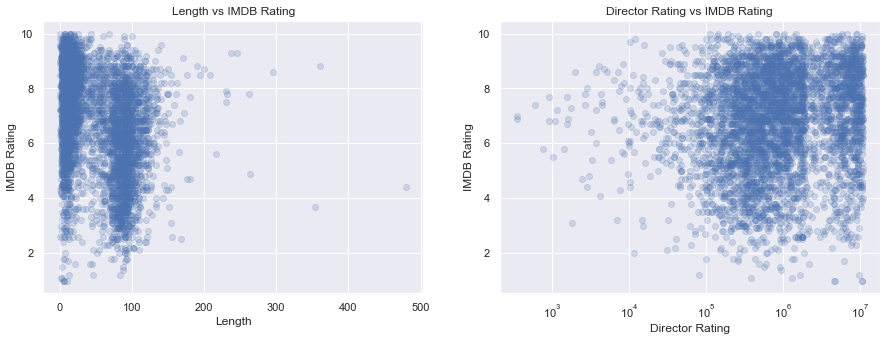

In [3]:
sns.set()
# creating length vs IMDB Rating plot
plt.subplot(1, 2, 1)
plt.scatter(final_df.length, final_df.averageRating, alpha=0.2);
plt.xlabel('Length');
plt.ylabel('IMDB Rating');
plt.title('Length vs IMDB Rating');

# creating director rating vs IMDB Rating plot
plt.subplot(1, 2, 2)
plt.scatter(final_df.director_rating, final_df.averageRating, alpha=0.2);
plt.xlabel('Director Rating');
plt.ylabel('IMDB Rating');
plt.title('Director Rating vs IMDB Rating');
plt.xscale('log');


# setting size of plot
plt.gcf().set_size_inches(15, 5)

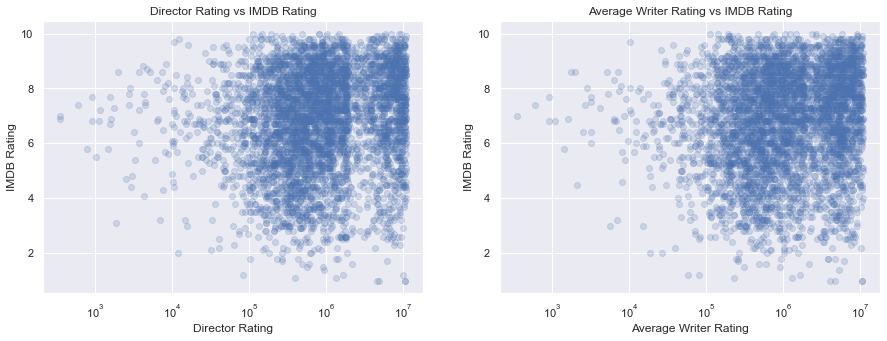

In [4]:
# creating director rating vs IMDB Rating plot
plt.subplot(1, 2, 1)
plt.scatter(final_df.director_rating, final_df.averageRating, alpha=0.2);
plt.xlabel('Director Rating');
plt.ylabel('IMDB Rating');
plt.title('Director Rating vs IMDB Rating');
plt.xscale('log');

# creating director rating vs IMDB Rating plot
plt.subplot(1, 2, 2)
plt.scatter(final_df.average_writer_rating, final_df.averageRating, alpha=0.2);
plt.xlabel('Average Writer Rating');
plt.ylabel('IMDB Rating');
plt.title('Average Writer Rating vs IMDB Rating');
plt.xscale('log')


# setting size of plot
plt.gcf().set_size_inches(15, 5)

In [5]:
# below are all of the genres used in this analysis
final_df.columns[2:29]

Index(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show',
       'Thriller', 'War', 'Western'],
      dtype='object')

# Model
As shown below, we are trying to predict a quantitative attribute with four quantitative attributes and one categorical attribute. Since we are trying to predict a quantitative attribute, we chose linear regression and random forest regression as our machine learning models. We chose these algorithms over classifiers or regular decision tree/random forest models because these are for predicting a categorical attribute, not a continuous one.

The linear regression approach will create a linear formula representing a straight line through the data which explains the highest possible amount of the variance. This will allow us to see which attributes contributed to increasing or decreasing IMDB Rating through the coefficient values. The random forest regressor allows us to see the feature importance based on gini impurity, giving us insight on which features are more important for determining IMDB Rating.

# Regression

In [6]:
final_df.head()

,titleId,level_1,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Western,title,averageRating,numVotes,director_name,budget,length,genres,director_rating,average_writer_rating
0,tt2765836,2,0,0,0,0,0,0,0,0,...,0,Hope Dancer,7.2,6,Aili Wang,5000.0,11.0,"['Short', 'Drama', 'Family']",1695839.0,1695839.0
1,tt2766788,1,0,0,0,0,0,0,0,0,...,0,Auroras,5.4,21,Niles Heckman,10000.0,5.0,"['Short', 'Sci-Fi']",1086737.0,1086737.0
2,tt2767440,2,0,0,0,0,0,0,0,0,...,0,Nocturne Six,2.9,150,Charlton Jacob Jacques,25000.0,80.0,"['Horror', 'Sci-Fi', 'Thriller']",472838.0,552421.0
3,tt2768766,2,0,0,0,0,1,0,0,1,...,0,Faith Connections,7.5,157,Pan Nalin,550000.0,115.0,"['Documentary', 'Biography', 'Drama']",86836.0,86836.0
4,tt2771800,1,1,0,0,0,0,0,0,0,...,0,Rigor Mortis,6.3,5546,Juno Mak,15000000.0,103.0,"['Action', 'Horror']",185085.0,311360.0


## Pearson's R test
First we try to find out what movie features are correlated to IMDB score.

In [7]:
from scipy.stats import pearsonr
from itertools import combinations

movie_feat_list = ['director_rating', 'average_writer_rating', 'numVotes', 'budget', 'length']
for feat in movie_feat_list:
    r, pval = pearsonr(final_df['averageRating'], final_df[feat])
    print(f'r: {r:.2f}, pval: {pval:.3e} between IMDB score and {feat}')

r: 0.12, pval: 5.024e-16 between IMDB score and director_rating
r: 0.12, pval: 6.456e-17 between IMDB score and average_writer_rating
r: 0.00, pval: 7.409e-01 between IMDB score and numVotes
r: -0.07, pval: 2.035e-06 between IMDB score and budget
r: -0.33, pval: 4.530e-124 between IMDB score and length


From the pvalues showed above, except numVotes, all other movie features have a pvalue less than 0.05, which means they are correlated to IMDB score.

## Linear Regression
Here, we build linear regression between different features and IMDB scores. First we try to use one single feature as x value. Below is a function for calculating the cross validated R2 value of a given regression model. We call this function for every linear regression we create.

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def cross_val_r2(x, y, model, degree=2, n_splits=10):
    """ computes cross validated r2 (regression performance on unseen data)
    
    Args:
        x(np.array): x value in model
        y(np.array): y value in model 
        model(str): sklearn model used for prediction
        degree(int): number of degree for polynomial regression model 
        n_splits(int): number of splits for kfold 
    
    Return:
        r2(float): cross validated r2 score 
    """
    
    # initialize x, y value, regression model and kfold 
    x_data = []
    y_data = []
    reg = LinearRegression()
    kfold = KFold(n_splits=n_splits)
    
    # initialize empty y predictions
    y_pred = np.empty_like(y)
    
    # set x,y value corresponding to the model used 
    if model == 'Linear':
        x_data = x
        y_data = y
    
    if model == 'Exp':
        x_data = x
        y_data = np.log(y)
    
    if model == 'Poly':
        
        # project x to polynomial
        poly_project = PolynomialFeatures(degree=degree)
        x_data = poly_project.fit_transform(x)
        y_data = y 
        
        reg = LinearRegression(fit_intercept=False)
    
    # use kfold for training 
    for train_idx, test_idx in kfold.split(x_data, y_data):
        
        
        # split data
        x_test = x_data[test_idx, :]
        x_train = x_data[train_idx, :]
        y_train = y_data[train_idx]
        
        # fit
        reg.fit(x_train, y_train)
        
        # predict
        y_pred[test_idx] = reg.predict(x_test)
        
        if model == 'Exp':
            y_pred[test_idx] = np.exp(reg.predict(x_test))
        
    # compute cross validated r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    return r2

#### Normalizing The Data
Before we fit the models, we must normalize the data. We compute the normalization below.

In [9]:
# check the variance of each movie feature 
final_df.var()

level_1                  5.928066e-01
Action                   8.838023e-02
Adult                    8.331593e-04
Adventure                4.300103e-02
Animation                2.001216e-02
Biography                1.941193e-02
Comedy                   1.777503e-01
Crime                    5.569933e-02
Documentary              8.686811e-02
Drama                    2.353352e-01
Family                   3.107298e-02
Fantasy                  3.437682e-02
Game-Show                0.000000e+00
History                  1.881091e-02
Horror                   1.456682e-01
Music                    2.359714e-02
Musical                  5.596844e-03
Mystery                  4.148070e-02
News                     3.324295e-03
Reality-TV               4.167535e-04
Romance                  4.658953e-02
Sci-Fi                   6.062985e-02
Short                    2.496923e-01
Sport                    1.031456e-02
Talk-Show                6.249998e-04
Thriller                 9.957766e-02
War         

In [10]:
# Scale Normalization 
# 'numVotes', 'budget', 'length'
for feat in ['averageRating', 'director_rating', 'average_writer_rating']:
    final_df[feat] = final_df[feat] / final_df[feat].std()

In [11]:
# check the variance of each movie feature 
final_df.var()

level_1                  5.928066e-01
Action                   8.838023e-02
Adult                    8.331593e-04
Adventure                4.300103e-02
Animation                2.001216e-02
Biography                1.941193e-02
Comedy                   1.777503e-01
Crime                    5.569933e-02
Documentary              8.686811e-02
Drama                    2.353352e-01
Family                   3.107298e-02
Fantasy                  3.437682e-02
Game-Show                0.000000e+00
History                  1.881091e-02
Horror                   1.456682e-01
Music                    2.359714e-02
Musical                  5.596844e-03
Mystery                  4.148070e-02
News                     3.324295e-03
Reality-TV               4.167535e-04
Romance                  4.658953e-02
Sci-Fi                   6.062985e-02
Short                    2.496923e-01
Sport                    1.031456e-02
Talk-Show                6.249998e-04
Thriller                 9.957766e-02
War         

### Linear Regression for Director Rating, Writer Rating vs IMDB rate Seperately:

Linear Regression model:
IMDB rate = 3.70 + 0.12 * director_rating
R2score = 0.01233153506746032

Linear Regression model:
IMDB rate = 3.68 + 0.12 * average_writer_rating
R2score = 0.012654631647228132



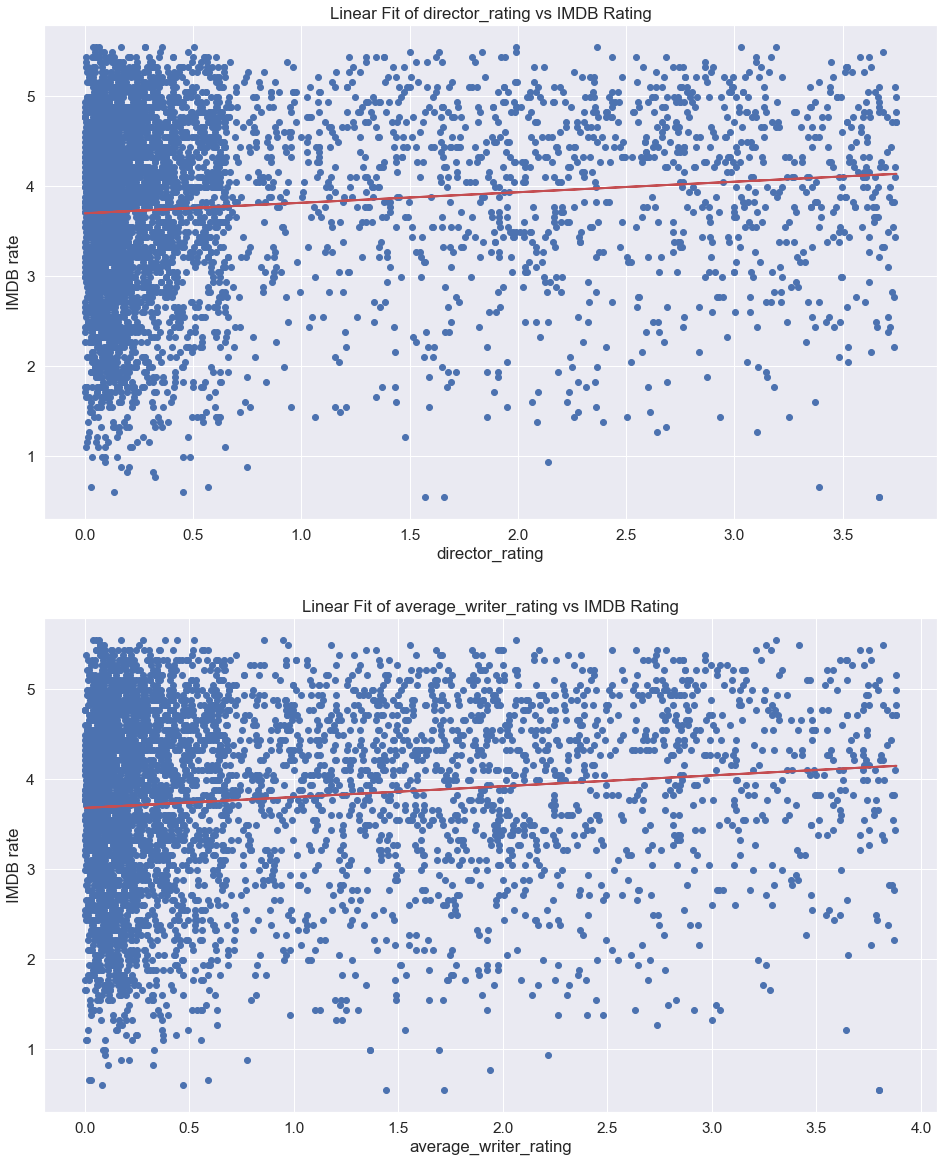

In [12]:
sns.set(font_scale=1.4)

feat_list = ['director_rating', 'average_writer_rating']

index = 1

for feat in feat_list:
    
    plt.subplot(len(feat_list), 1, index)
    
    # get x,y value 
    x = final_df.loc[:, feat].values
    y_true = final_df['averageRating'].values 

    # reshape x value to fit model 
    x = x.reshape(-1, 1)

    # Linear regression model 
    reg_linear = LinearRegression()
    reg_linear.fit(x, y_true)
    y_pred_linear = reg_linear.predict(x)
    r2_linear = cross_val_r2(x, y_true, model='Linear')
    model_str = f'IMDB rate = {reg_linear.intercept_:.2f} + {reg_linear.coef_[0]:.2f} * {feat}'
    print('Linear Regression model:')
    print(model_str)
    print(f'R2score = {r2_linear}\n')
    
    # scatter samples 
    plt.scatter(x, y_true, label='samples')

    # plot Linear Regression 
    plt.plot(x, y_pred_linear, linewidth=2, color = 'r', label=f'linear model r2={r2_linear}')

    plt.xlabel(f'{feat}')
    plt.ylabel('IMDB rate')
    plt.title(f'Linear Fit of {feat} vs IMDB Rating');
    plt.gcf().set_size_inches(16, 20)
    # adjust place between each subplots to look nicer
    plt.subplots_adjust(hspace=.20)
    
    index += 1
    

## Explanation
It is clear from the graphs that the linear regression lines do not fit the data distribution very well. The data is clustered mostly towards the left of the plot and and the IMDB Rating has a high variance, making it hard for the linear regression to explain a lot of the variance.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

### Budget and Length vs IMDB rate Seperately
Again, before we fit the model, we need to normalize the features, which we did below.

In [13]:
for feat in ['numVotes', 'budget', 'length']:
    final_df[feat] = final_df[feat] / final_df[feat].std()

Linear Regression model:
IMDB rate = 3.79 + -0.07 * budget
R2score = 0.00326756234319725

Linear Regression model:
IMDB rate = 4.18 + -0.33 * length
R2score = 0.10931730015922247



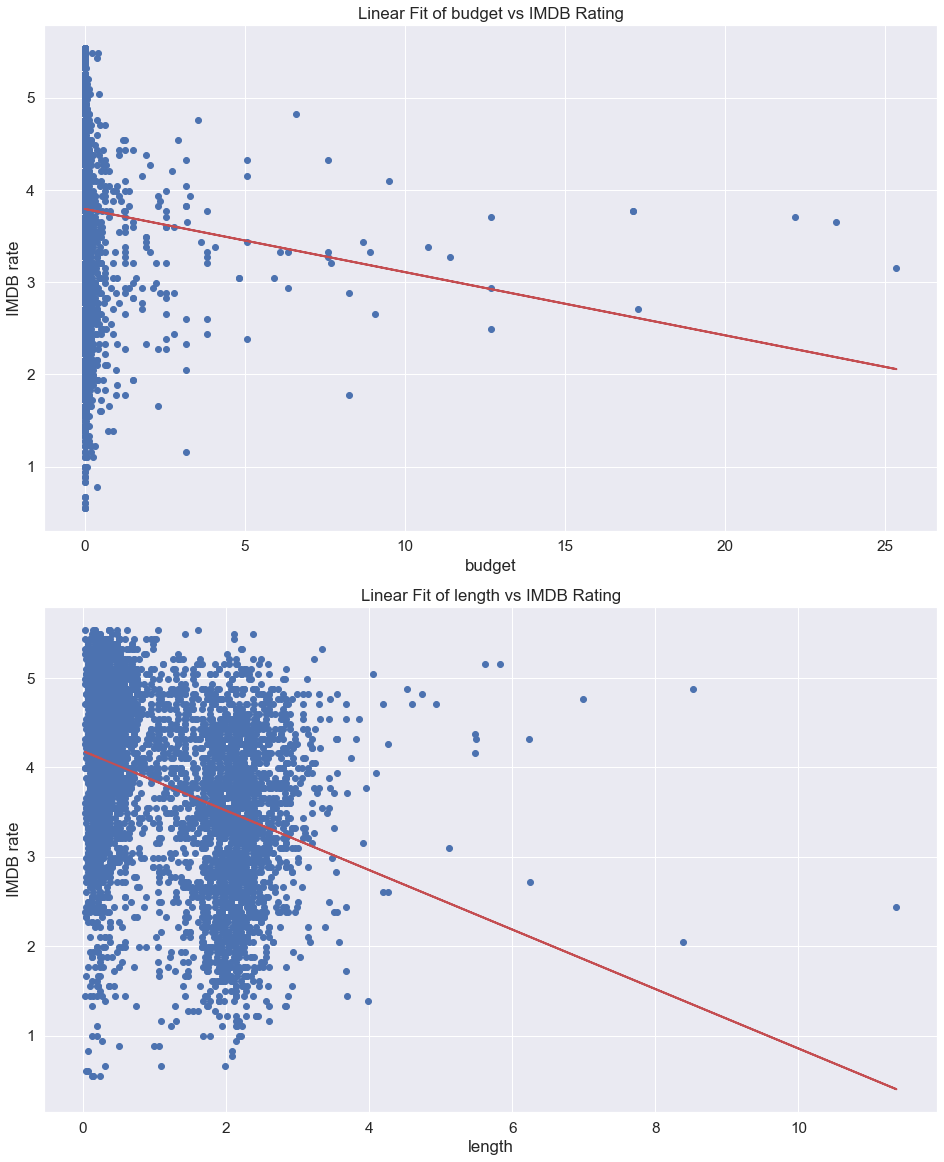

In [14]:
feat_list = ['budget', 'length']

index = 1

for feat in feat_list:
    
    plt.subplot(len(feat_list), 1, index)
    
    # get x,y value 
    x = final_df.loc[:, feat].values
    y_true = final_df['averageRating'].values 

    # reshape x value to fit model 
    x = x.reshape(-1, 1)

    # Linear regression model 
    reg_linear = LinearRegression()
    reg_linear.fit(x, y_true)
    y_pred_linear = reg_linear.predict(x)
    r2_linear = cross_val_r2(x, y_true, model='Linear')
    model_str = f'IMDB rate = {reg_linear.intercept_:.2f} + {reg_linear.coef_[0]:.2f} * {feat}'
    print('Linear Regression model:')
    print(model_str)
    print(f'R2score = {r2_linear}\n')
    
    # scatter samples 
    plt.scatter(x, y_true, label='samples')

    # plot Linear Regression 
    plt.plot(x, y_pred_linear, linewidth=2, color = 'r', label=f'linear model r2={r2_linear}')

    plt.xlabel(f'{feat}')
    plt.ylabel('IMDB rate')
    plt.title(f'Linear Fit of {feat} vs IMDB Rating');
    plt.gcf().set_size_inches(16, 20)
    # adjust place between each subplots to look nicer
    plt.subplots_adjust(hspace=.15)
    
    index += 1

## Explanation
It is clear from the graphs that the linear regression lines do not fit the data distribution very well. Most of the data is clustered around the left sides of the plots, and do not show a nice correlation between IMDB Rate and length and budget.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

### Genre vs IMDB rate

In [15]:
# get genre columns 
genre_columns = final_df.columns[2:29]

Linear Regression model:
IMDB rate = 3.33 + -0.15 Action + 0.17 Adult + -0.01 Adventure + -0.05 Animation + 0.21 Biography + 0.09 Comedy + -0.04 Crime + 0.66 Documentary + 0.17 Drama + -0.01 Family + -0.14 Fantasy + 0.00 Game-Show + 0.00 History + -0.46 Horror + 0.09 Music + 0.33 Musical + 0.00 Mystery + 0.21 News + 1.20 Reality-TV + 0.03 Romance + -0.29 Sci-Fi + 0.85 Short + 0.01 Sport + -0.78 Talk-Show + -0.17 Thriller + -0.17 War + -0.17 Western
R2score = 0.2524699117127036



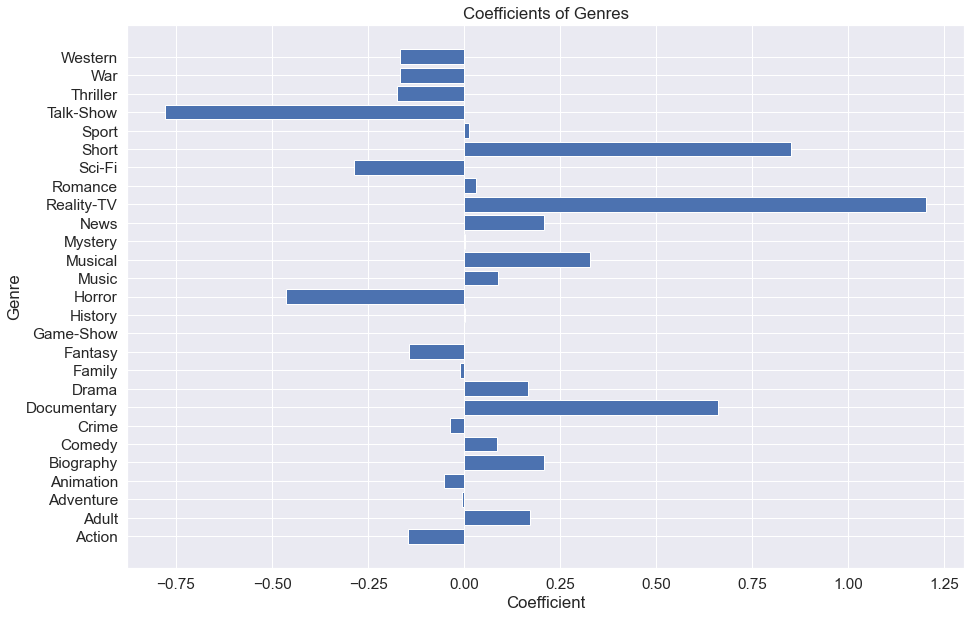

In [16]:
# get x,y value 
x = final_df.loc[:, genre_columns].values
y_true = final_df['averageRating'].values 

# Linear regression model 
reg_linear = LinearRegression()
reg_linear.fit(x, y_true)
y_pred_linear = reg_linear.predict(x)
r2_linear = cross_val_r2(x, y_true, model='Linear')
model_str = f'IMDB rate = {reg_linear.intercept_:.2f}'
for feat, coef in zip(genre_columns, reg_linear.coef_):
    model_str += f' + {coef:.2f} {feat}'
print('Linear Regression model:')
print(model_str)
print(f'R2score = {r2_linear}\n')

plt.figure(figsize=(15,10));
plt.barh(genre_columns, reg_linear.coef_);
plt.title('Coefficients of Genres');
plt.ylabel('Genre');
plt.xlabel('Coefficient');

## Explanation
The R2 for genre is 0.25 which is the largest R2 value among all movie features so far. Although the prediction of IMDB was not very succesful, the regression still computed relevant coefficient values for every genre. It is clear tht some genres lend themselves to higher rated movies and some lend themselves to lower rated movies.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

### Combine all  features together 
<a id='Linear_Regression_R2'></a>

Linear Regression model:
IMDB rate = 3.18 + -0.13 Action + 0.16 Adult + -0.02 Adventure + -0.05 Animation + 0.24 Biography + 0.09 Comedy + -0.04 Crime + 0.64 Documentary + 0.17 Drama + -0.00 Family + -0.15 Fantasy + -0.00 Game-Show + -0.02 History + -0.46 Horror + 0.08 Music + 0.34 Musical + -0.01 Mystery + 0.23 News + 1.27 Reality-TV + 0.02 Romance + -0.29 Sci-Fi + 0.90 Short + 0.03 Sport + -0.91 Talk-Show + -0.17 Thriller + -0.14 War + -0.17 Western + 0.00 budget + 0.03 length + 0.03 director_rating + 0.07 average_writer_rating
R2score = 0.259597707925623



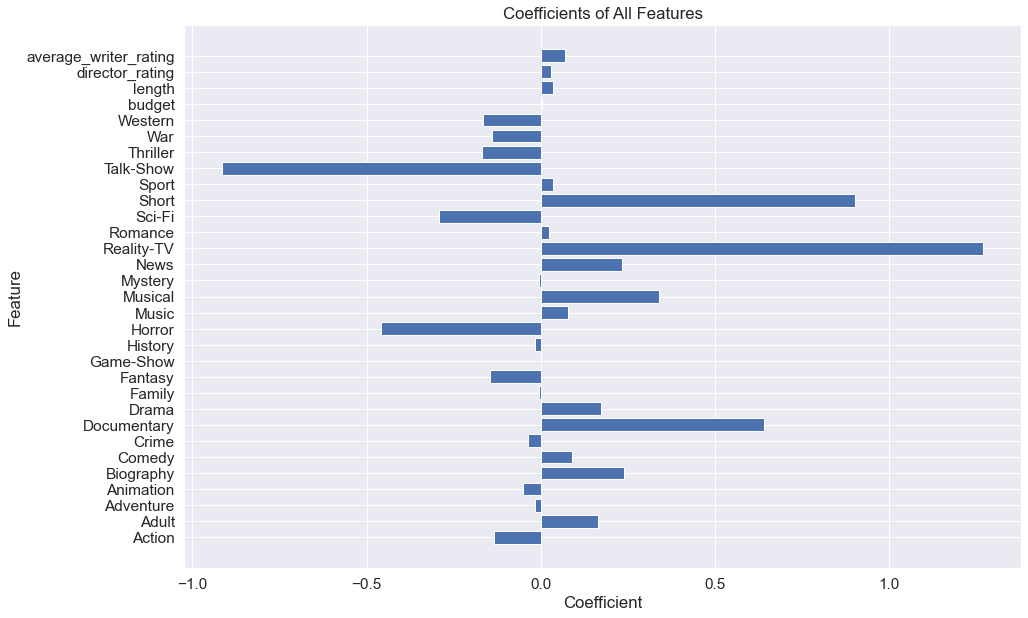

In [17]:
# get feature list combining genres and other features 
feat_list = ['budget', 'length', 'director_rating', 'average_writer_rating']
feature_columns = list(genre_columns)
feature_columns.extend(feat_list)

# get x,y value 
x = final_df.loc[:, feature_columns].values
y_true = final_df['averageRating'].values 

# Linear regression model 
reg_linear = LinearRegression()
reg_linear.fit(x, y_true)
y_pred_linear = reg_linear.predict(x)
r2_linear = cross_val_r2(x, y_true, model='Linear')
model_str = f'IMDB rate = {reg_linear.intercept_:.2f}'
for feat, coef in zip(feature_columns, reg_linear.coef_):
    model_str += f' + {coef:.2f} {feat}'
print('Linear Regression model:')
print(model_str)
print(f'R2score = {r2_linear}\n')

plt.figure(figsize=(15,10));
plt.barh(feature_columns, reg_linear.coef_);
plt.title('Coefficients of All Features');
plt.ylabel('Feature');
plt.xlabel('Coefficient');

## Explanation
According to the R2 value of around 0.26, the prediction is still not very succesful. However, there are again relevant coeffient vaues from the model which show how much each feature affects IMDB Rating.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

# Random Forest Regressor
Next, we will use a random forest regressor to predict IMDB Rating. First, we will train the model on budget, length, director_rating, and average_writer_rating separately. Then we will train it on all of these features together. After, we will train the model on genre using the one-hot encoding and then finally train the model on all of the features combined.

Below is a function for computing the cross validated r2 for the given data using given features.

In [18]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_r2(x, y, feature_list, max_depth=4):
    ''' computes cross validated r2 on given data
    
    Args:
        x(np.array): x value in model
        y(np.array): y value in model 
        max_depth(int): depth of random forest regressor
    
    Return:
        r2(float): cross validated r2 score 
    '''
    kfold = KFold(n_splits=10)
    
    # creates random forest regressor
    random_forest = RandomForestRegressor(n_estimators=10, max_depth=max_depth)
    
    # define x and y
    x = final_df.loc[:, feature_list].values
    y = final_df['averageRating'].values 
    
    # initializes list holding predictions
    y_pred_rf = np.empty_like(y)
    
    for train_idx, test_idx in kfold.split(x, y):
        # split data
        x_test = x[test_idx, :]
        x_train = x[train_idx, :]
        y_train = y[train_idx]

        # trains the random forest
        random_forest.fit(x_train, y_train)

        # adds predictions to y_pred_rf
        y_pred_rf[test_idx] = random_forest.predict(x_test)
    
    r2 = r2_score(y_true=y, y_pred=y_pred_rf)
    
    return r2

Below, we find the cross validated R2 value for every individual feature.

Cross validated R2 for budget: 0.06788566486623782
Cross validated R2 for length: 0.1690612905333152
Cross validated R2 for director_rating: 0.017365813053978663
Cross validated R2 for average_writer_rating: 0.010170779566599286


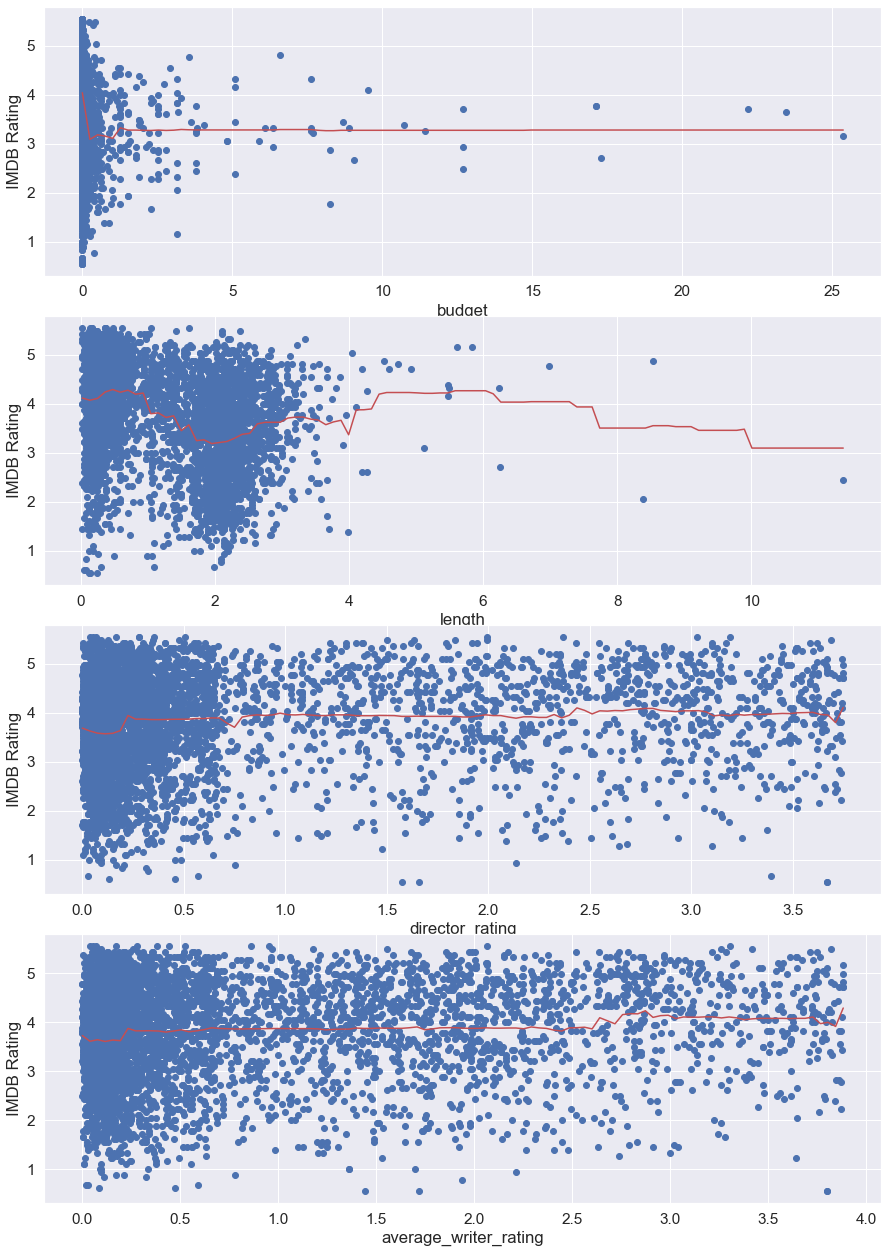

In [19]:
features = ['budget', 'length', 'director_rating', 'average_writer_rating']

for idx, f in enumerate(features):

    plt.subplot(len(features), 1, idx+1)

    # define x and y
    x = final_df.loc[:, f].values.reshape(-1, 1)
    y = final_df['averageRating'].values

    # plot data
    plt.scatter(x, y);

    # initialize regressor
    random_forest = RandomForestRegressor(max_depth=4)

    # trains the random forest
    random_forest.fit(x, y)

    # print cross validated R2
    current_r2 = random_forest_r2(x, y, [f], max_depth=4)
    print(f'Cross validated R2 for {f}: {current_r2}')

    x_plot = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
    y_plot_pred = random_forest.predict(x_plot)
    plt.plot(x_plot, y_plot_pred, color='r');
    plt.xlabel(f);
    plt.ylabel('IMDB Rating');
    
    plt.gcf().set_size_inches(15, 22)
    # adjust place between each subplots to look nicer
    plt.subplots_adjust(hspace=.15)

## Explanation
Although the regressor plotted lines through the data, it is clear at a first glance that they do not explain much of the variance in the data. This is reflected in the low R2 values.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

- All of the R2 values are extremely low, suggesting that our model explains very little of the variance in the data. - The feature with the highest R2 is length, suggesting that it is the most effective out of the four features for predicting IMDB rating
- The feature with the lowest R2 is average_writer_rating, suggesting that is it the least effective out of the four features for predicting IMDB rating

### Budget, Length, Director_rating, and Average_writer_rating Seperately
We will now get the cross validated R2 values for budget, length, director_rating, average_writer_rating all at once. And plot the feature imporatance. We will use a max_depth of 7 because there are more features being used. Any max_depth higher than 7 seems to reduce the R2.

Cross validated R2: 0.18325912313331738


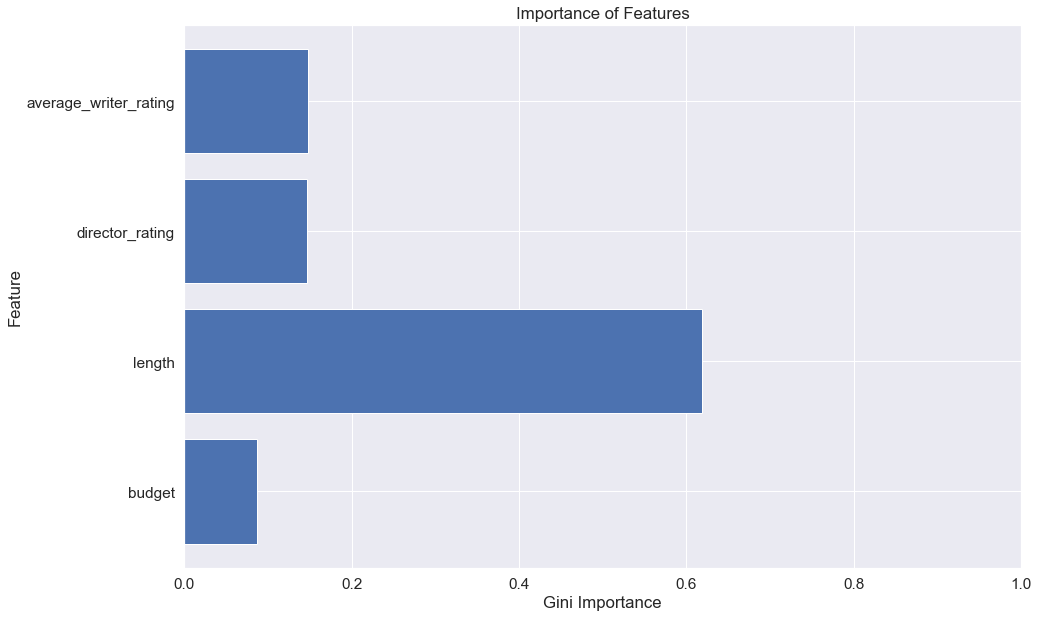

In [20]:
# define features
feat_list = ['budget', 'length', 'director_rating', 'average_writer_rating']

# define x and y
x = final_df.loc[:, feat_list].values
y = final_df['averageRating'].values 

# initialize regressor
random_forest = RandomForestRegressor(max_depth=7)

# trains the random forest
random_forest.fit(x, y)

plt.figure(figsize=(15,10)) 
plt.barh(feat_list, random_forest.feature_importances_);
plt.xlim(0, 1);
plt.title('Importance of Features');
plt.ylabel('Feature');
plt.xlabel('Gini Importance');

print(f'Cross validated R2: {random_forest_r2(x, y, feat_list)}')

## Explanation
At a first glance, this graph displays the importance of the features used in this model before adding genre. Length clearly has the highest gini importance in the regressor while budget has the lowest importance.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

The R2 with all four features is higher than training the model on any one feature, but not by that much. The R2 with just length was around 0.16, while the model using all four features was around 0.18. This means that taking average_writer_rating, director_rating, and budget into consideration helped our model slightly compared to just using length.

### Genres
Next, we will fit the regressor using just genres and get the cross validated R2 and feature importances.

Cross validated R2: 0.25495742398835475


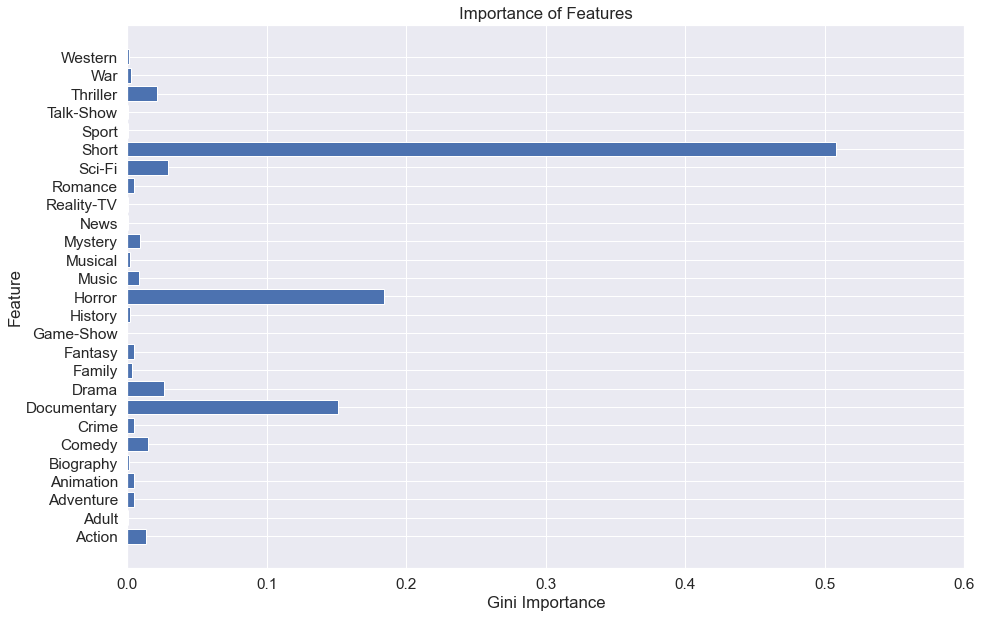

In [21]:
# define x and y
x = final_df.loc[:, genre_columns].values
y = final_df['averageRating'].values 

# initialize regressor
random_forest = RandomForestRegressor(max_depth=6)

# trains the random forest
random_forest.fit(x, y)

plt.figure(figsize=(15,10)) 
plt.barh(genre_columns, random_forest.feature_importances_);
plt.xlim(0, 0.6);
plt.title('Importance of Features');
plt.ylabel('Feature');
plt.xlabel('Gini Importance');

print(f'Cross validated R2: {random_forest_r2(x, y, genre_columns)}')

## Explanation
Out of all the genres, short, horror, and documentary seem to be the most important.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

### Combined Data
<a id='Random_Forest_R2'></a>

Finally, we will fit the regressor using all of the relevant attributes and get the cross validated R2. We will also determine the feature importance to see which features are the most relevant for determining IMDB Rating.

Cross validated R2: 0.26002165685606604


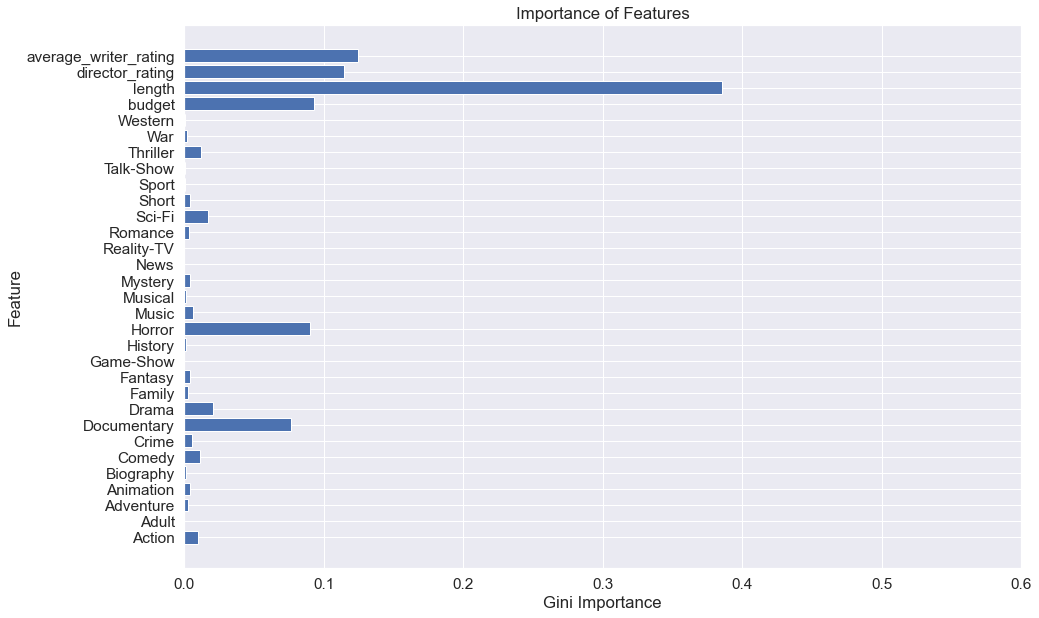

In [22]:
# define x and y

x = final_df.loc[:, feature_columns].values
y = final_df['averageRating'].values 

# initialize regressor
random_forest = RandomForestRegressor(max_depth=10)

# trains the random forest
random_forest.fit(x, y)

plt.figure(figsize=(15,10)) 
plt.barh(feature_columns, random_forest.feature_importances_);
plt.xlim(0, 0.6);
plt.title('Importance of Features');
plt.ylabel('Feature');
plt.xlabel('Gini Importance');

print(f'Cross validated R2: {random_forest_r2(x, y, feature_columns)}')

## Explanation
Out of all the features, length seems to maintain its highest importance. Out of the genres, horror and documantary also maintain their higher importance; however, short seems to have lost importance when including the rest of the features in the model.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

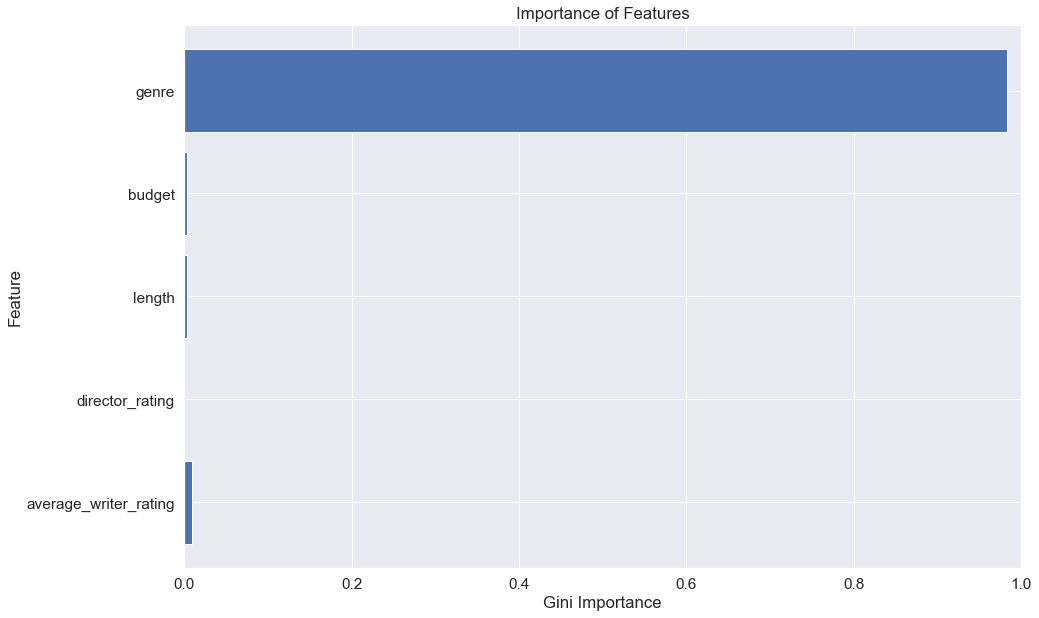

In [23]:
feature_importances = list(random_forest.feature_importances_[0:4])
genre_features = sum(random_forest.feature_importances_[4:])
feature_importances.append(genre_features)

plt.figure(figsize=(15,10)) 
plt.barh(['average_writer_rating', 'director_rating', 'length', 'budget', 'genre'], feature_importances);
plt.xlim(0, 1);
plt.title('Importance of Features');
plt.ylabel('Feature');
plt.xlabel('Gini Importance');

## Explanation
When we add up the gini importances of all of the genres, it is clear that it is by far the most important feature when determining IMDB Rating.

We discuss the interpretation of the graph results in the context of the problem in the [discussion](#discussion) section of this notebook.

# Discussion
<a id='discussion'></a>

interpretations for each graph here

final takeaways

## Interpret Results

### Linear Regression
- single attribute: director_rating vs IMDB
    - R2 of 0.01
        - This is quite low, but reasonable given the state of the data
    - Positive coefficient
        - Suggests a positive impact on IMDB Score
        - This is expected, as it makes sense that movies with higher rated directors would have higher IMDB Ratings

- single attribute: average_writer_rating vs IMDB
    - R2 of 0.01. This is very low
        - This is quite low, but reasonable given the state of the data
    - Positive coefficient
        - Suggests a positive impact on IMDB Score
        - This is expected, as it makes sense that movies with higher rated writers would have higher IMDB Ratings

- single attribute: budget vs IMDB
    - R2score is only 0.003, which is the smallest in this case, suggesting that budget is the least relevent feature for predicting IMDB score thus far
        - This was not necessarily expected, but it is not surprising. The amount of money that goes into making a movie does not necessarily determine its quality as a movie overall. Many other factors go into creating a good movie such as, actors, plot, and and even music soundtrack
    - Graphs show that samples are mostly gathered on the left, causing a very uneven distribution with some outliers having much larger values

- single attribute: length vs IMDB
    - R2score is 0.1 which is the largest in this case, suggesting that length is the most relevent feature for predicting IMDB score thus far
    - The coefficient of length vs IMDB is negative, suggesting that longer movies typically have lower IMDB score
        - The above two observations were not expected, but they are not surprising. It would make sense that extremely long movies have worse ratings. In longer movies, there is more possibility for errors to be made and it is usually hard to make it interesting for the entire length of the long movie
        
- single attribute: genre vs IMDB
    - R2 score is 0.25, which is the largest R2 value among all movie features, so it suggests that genre is a key factor contributing to IMDB score.
        - This makes sense, as there are definitely certain genres of movies that are more popular than others. However, some of the specific positive and negative genres are surprising. So far, this is the most significant developement in our analysis, as the R2 value increased significantly.
    - Reality-TV has the maximum coefficient of 1.20, suggesting that it is the highest rated genre.
        - This is not surprising, as reality-TV programs tend to be very popular; however, this introduces a problem in the dataset. We may have made our definition of a movie too broad in this analysis, thus negatively impacting our predictions. We mention this lating in the discussion as well.
    - Talk-Show has the minimum coefficient of -0.78, suggesting that it is the lowest rated genre. 
        - This was not surprising but we would not have guessed that this is the case. From our viewpoint, talkshows are relatively popular; however, maybe this just reveals our misconsceptions about the TV/Movie industry.
    - Game-Show, History and Mystery have coefficients as 0, suggesting that these genres won't impact IMDB score.
        - This is neither surpising nor expected. Given our previous conceptions, we would not have guessed that these genres were less popular 
- all attributes: director_rating, average_writer_rating, budget, length, and genre vs IMDB
    - R2 score is higher than the previous model with only genres as x, so additional features other than genres are helpful to predict IMDB rate when training with genres. 
    - Reality-TV and Talk-Show are still the highest and lowest rated genre respectively.
    - The coefficient of budget is closely equals to 0 in this case, suggesting that it has less influence to IMDB rate than other features. 
    - The coefficient of length turns positive in this case from a previous negative without including genre, suggesting that length may have an uncertain impact to IMDB rate.  
        - We think that this change in sign may have occurred because the "short" genre has a strong correlation with the length attribute. It would make sense that movies with shorter lengths would fall under the "short" genre category. A positive coefficient on the short genre means the same thing as a negative coefficient on the length genre, so the logic still holds in terms of what makes a movie good or not. However, it is possible that the length coefficient is now positive because a movie that is considered "short" would not be changed much by a small increase in length. In other words, the length is offset by the "short" genre being included in the model.
    - talk-show, sci-fi, and horror are the lowest rated genres
        - This is consistent with the previous genre model and it is not surprising but not expected. From our experience, horror movies having lower ratings makes sense, but we are not knowledgable enough to say anything about talk-shows or sci-fi.
    - Reality-TV, documentary, biography, and short are the highest rated genres
        - This is as expected, as reality-tv tends to be extremely popular given the inevitable drama and documentaries and biographies can be quite powerful

### Random Forest Regressor
In this section, we basically repeated the process that we used for the linear regressions. We fit a model for every feature seperately first, and then fit a model with all of the features combined. The cross validated R2 values were basically the same for the random forest, so the analysis is the same as the linear regression analysis above. The only difference is that we were able to calculate the gini importances for the features. We discuss the relevant insights from this metric below.

- Refering to the model with director_rating, average_writer_rating, budget, and length, length (first four attributes) has the highest gini importance. This is consistent with the linear regression, as it had the highest R2 out of all of the first four attributes.

- In the model with genre, short, horror, and documentary showed themselves to be the most important attributes. This, however, is very different from the linear regression model with genre. The linear regression model with genre had reality-tv, talk-show, and sci-fi as features with large coefficientsj; however, they did not prove to be important in the regressor model.
    - We are not exactly sure why this is the case. We are assuming this simply occured because the random forest regressor is simply a different type of algorithm than the linear regression. This does go to show that none of these results should be accepted at face value, as there can be differing results between two algorithms trained on the same data.
    
- In the model with all of the features, these feature importances line up with the results from the linear regression model. Length shows itself to be the most important out of the first four features, and genre is still by far the most important feature. The feature importance graph shows that each individual genre is less important than the first four features. This makes sense because we used a one-hot encoding for genre, so every unique type of genre will have a lower importance than the other quantitative features. However, when you add up the importances of all of the genres, it is clear that genre has the largest impact on IMDB rating.

## Takeaways

Our project did not succeed in predicting IMDB rating. All of our models produced relatively low R2 values.

What went wrong:
1. Including movies from all time periods in our dataset.
    - Our data had movies from a massive time period range. Maybe focusing on more recent movies would have given us more accurate predictions, as the style of movies has changed a lot over time.
    - A movie made 100 years ago may have a high rating, but have drastically different attributes such as director and writer ratings, budget, and length.
    - **We'd suggest only working with a subet of movies at a time, each with movies from a certain time period. EX: train the models on movies from the past 20 years. This should produce a more accurate result for predicting IMDB ratings.**
2. The way STARmeter are calculated on IMDB may not make it a very accurate predictor for IMDB movie rating
    - For our director and writer ratings in the data, we used the STARmeter metric on the IMDB Pro website. STARmeter is calculated based on page views on the website and is recalculated every week. Thus, it is not a very good metric for determining how effective or skillful a certain cast member is. Good movies are created by cast members that are "good" at their job, not just popular. It possible that something that is not of high quality can still be popular. Since IMDB Rating is a measure of quality in a movie, not popularity based on page visits, using the weekly STARmeter may not have been the best choice for predicting movie rating.
    - **We'd suggest using the number of awards for directors and writers, as this may be a better metric for determining quality of performance, which would more likely affect IMDB Rating. Awards can be scraped from IMDB Pro as well, it would just require a different script.**
    
3. Potential issues with genres
    - A lot of our movies were not really movies. Many of them had very short lengths, which increased the variability in the dataset and would explain why length was relatively important for determining IMDB rating. Movies with a 10 minute length should not be considered movies for our purposes here.
    - The "short" genre represents the length of the movie, which means that there is probably a tight correlation between short genre movies and their lengths.
    - Some of the very specific genres can be grouped into more broad genre bins
    - Included tv shows and tv serieses, which are also not movies
    - Overall, we made our definition of movies to broad for this project. We included programs which were too short in length or technically considered TV shows.
    - **We'd suggest excluding movies with genres including short, tv show, and tv series. This would reduce the variability of the length of movies and would ensure that only actual movies are included in the data. This also automatically makes our definition of a movie more specific.**
    
Positive remarks:
1. determining the most important features from regressor model
    - short, horror, and documentary were the top three most important genres according to the regressor model; however, this does not show whether they impacted IMDB rating negatively or positively
    - genre was by far the most important feature when determining IMDB rating
2. Use of One-hot encoding for genres
    - when dealing with training a model using categorical features to predict a continuous variable, you must change the feature to one-hot encoded columns with one for every unique feature included in the categorical variable
3. The regression model showed which features tend to increase or decrease IMDB rating 
    - Director_rating and average_writer_rating had positive coefficients, showing that usually higher rated IMDB movies have higher rated directors and writers
    - Movies that fall into the genre categories of talk-show, sci-fi, and horror tend to have lower IMDB ratings
    - Movies that fall into the genre categories of Reality-TV, documentary, biography, and short tend to have higher IMDB ratings
    